# Calculate Fourier parameters from shape data

In this tutorial we take a look at how to construct Harmonica's Fourier parameterisation of a transmission string from shape data. This is useful for forward modelling transit light curves of various objects with known shapes. You only need to determine some high-order Fourier representation of the shape, and then you may easily simulate high-precision light curves.

Let us start by loading some shape data. Here is some data made earlier, based on the transit of [Phobos](<https://mars.nasa.gov/news/9172/nasas-perseverance-rover-captures-video-of-solar-eclipse-on-mars/>) as viewed from the Perseverance rover on Mars.

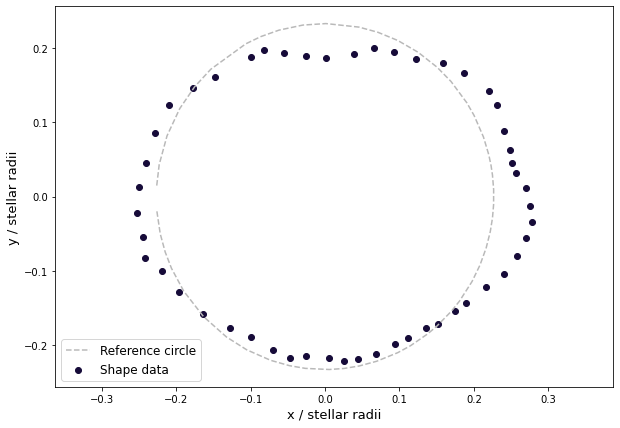

In [1]:
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt


r_data = np.array([ 0.25299594, 0.25049962, 0.2555872 , 0.24131962, 0.23499399, 0.2281387 , 0.21770261, 0.21355986, 0.21756298, 0.22216417, 0.215748  , 0.21737008, 0.22181932, 0.22220379, 0.22215942, 0.2191899 , 0.22060524, 0.22316191, 0.22795516, 0.23203883, 0.23715028, 0.24817015, 0.26129245, 0.2701211 , 0.27631858, 0.279554  , 0.27550068, 0.26970037, 0.25844681, 0.2551263 , 0.2564253 , 0.25649795, 0.2619272 , 0.26137834, 0.24959362, 0.23925815, 0.2218478 , 0.21541933, 0.21006674, 0.1952882 , 0.18672611, 0.19014673, 0.20044651, 0.2134876 , 0.21243847, 0.21826262, 0.23046709, 0.24290151, 0.24455098, 0.24425059, 0.25006916])
theta_data = np.array([-3.05626382, -2.92458806, -2.81512117, -2.71398938, -2.56361121, -2.37500762, -2.19475882, -2.05340439, -1.89915229, -1.78311113, -1.68792003, -1.54576688, -1.45830389, -1.36707739, -1.26004262, -1.12498761, -1.03931859, -0.91754355, -0.8460734 , -0.72241586, -0.64825102, -0.51378753, -0.40700302, -0.30187693, -0.20512046, -0.1247507 , -0.0469304 , 0.04035871, 0.12437005, 0.17993957, 0.24397848, 0.35182409, 0.48800481, 0.57248726, 0.72834884, 0.84510295, 0.98657143, 1.12488908, 1.2518673 , 1.36829014, 1.56557413, 1.70233616, 1.84736078, 1.96211635, 2.0600249 , 2.31436316, 2.4535093 , 2.60749337, 2.78292412, 2.95552791, 3.08844006])

plt.figure(figsize=(10, 7))
plt.gca().set_aspect("equal", "datalim")
plt.scatter(r_data * np.cos(theta_data), r_data * np.sin(theta_data), 
            color=cm.inferno(0.1), label="Shape data")
plt.plot(0.2267 * np.cos(theta_data), 0.2324 * np.sin(theta_data), 
         color="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("x / stellar radii", fontsize=13)
plt.ylabel("y / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

In polar coordinates:

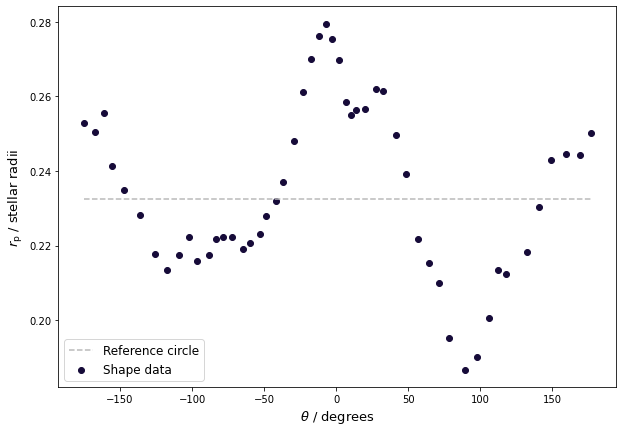

In [2]:
plt.figure(figsize=(10, 7))
plt.scatter(theta_data * 180. / np.pi, r_data,
            color=cm.inferno(0.1), label="Shape data")
plt.plot(theta_data * 180. / np.pi, 0.2324 * np.ones(theta_data.shape[0]),
         color="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

The Fourier parameters of Harmonica's transmission strings can be calculated from these data. This involves solving:

$$
a_0 = \frac{1}{2 \pi} \int_{-\pi}^{\pi} r(\theta) \,d \theta,
$$

$$
a_n = \frac{1}{\pi} \int_{-\pi}^{\pi} r(\theta) \cos{(n \theta)} \,d \theta,
$$

$$
b_n = \frac{1}{\pi} \int_{-\pi}^{\pi} r(\theta) \sin{(n \theta)} \,d \theta,
$$

where each integrand is a generated interpolation function based on the data. You can compute these coefficients up to a high order, although be careful of going too far as numerical ringing starts to appear. Here let us compute up to $n = 10$.

In [3]:
from scipy import interpolate, integrate


transmission_string_params = []
for n in range(11):

    if n == 0:
        # a_0 term.
        integrand_cos0_func = interpolate.interp1d(
            theta_data, r_data, 
            kind="cubic", bounds_error=False, fill_value="extrapolate")
        cn = integrate.quad(
            integrand_cos0_func, -np.pi, np.pi,
            epsabs=1.e-7, epsrel=1.e-7, limit=500)[0] / (2. * np.pi)
        transmission_string_params.append(cn)
    else:
        # a_n terms.
        integrand_cosn_func = interpolate.interp1d(
            theta_data, r_data * np.cos(n * theta_data), 
            kind="cubic", bounds_error=False, fill_value="extrapolate")        
        cn = integrate.quad(
            integrand_cosn_func, -np.pi, np.pi,
            epsabs=1.e-7, epsrel=1.e-7, limit=500)[0] / (1. * np.pi)
        transmission_string_params.append(cn)

        # b_n terms.
        integrand_sinn_func = interpolate.interp1d(
            theta_data, r_data * np.sin(n * theta_data), 
            kind="cubic", bounds_error=False, fill_value="extrapolate")
        sn = integrate.quad(
            integrand_sinn_func, -np.pi, np.pi,
            epsabs=1.e-7, epsrel=1.e-7, limit=500)[0] / (1. * np.pi)
        transmission_string_params.append(sn)

transmission_string_params = np.array(transmission_string_params)

Now plot the resulting transmission string and check you have a good approximation of your input shape:

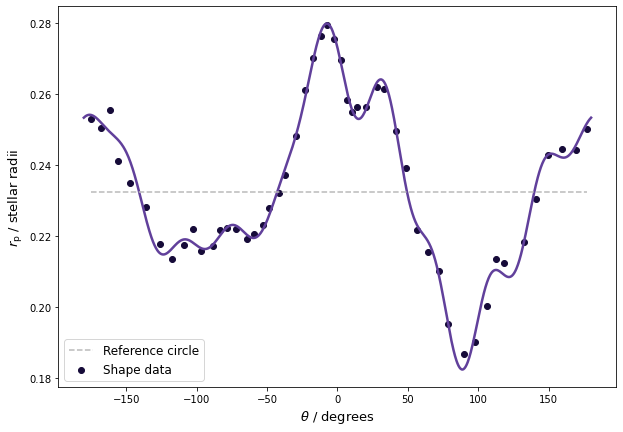

In [4]:
from harmonica import HarmonicaTransit


ht = HarmonicaTransit()
ht.set_planet_transmission_string(transmission_string_params)
theta = np.linspace(-np.pi, np.pi, 1000)

plt.figure(figsize=(10, 7))
plt.plot(theta * 180. / np.pi, ht.get_planet_transmission_string(theta),
         c=cm.Purples(0.8), lw=2.5)
plt.scatter(theta_data * 180. / np.pi, r_data,
            color=cm.inferno(0.1), label="Shape data")
plt.plot(theta_data * 180. / np.pi, 0.2324 * np.ones(theta_data.shape[0]),
         color="#b9b9b9", ls="--", label="Reference circle")
plt.xlabel("$\\theta$ / degrees", fontsize=13)
plt.ylabel("$r_{\\rm{p}}$ / stellar radii", fontsize=13)
plt.legend(loc="lower left", fontsize=12)
plt.show()

These parameters can now be used to generate transit light curves of your object. The only thing left to do is specify the orbit and stellar limb darkening.

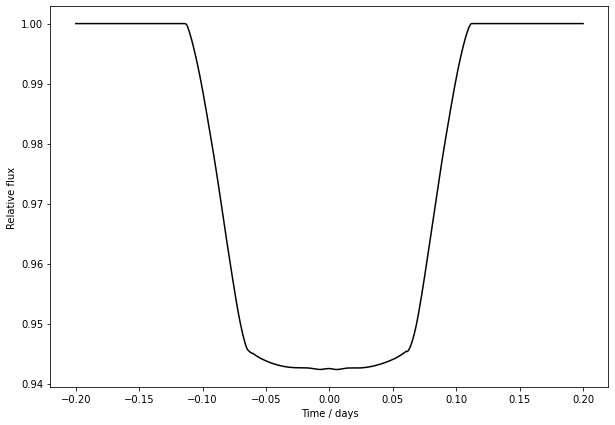

In [5]:
times = np.linspace(-0.2, 0.2, 500)
ht = HarmonicaTransit(times)
ht.set_orbit(t0=0., period=4., a=7., inc=88. * np.pi / 180.)
ht.set_stellar_limb_darkening(u=np.array([0.074, 0.193]), limb_dark_law="quadratic")
ht.set_planet_transmission_string(transmission_string_params)
light_curve = ht.get_transit_light_curve()

plt.figure(figsize=(10, 7))
plt.plot(times, light_curve, c="#000000")
plt.xlabel('Time / days')
plt.ylabel('Relative flux')
plt.show()